In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [193]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

In [194]:
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

In [195]:
# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

# XGboost

In [196]:
# 定义XGBoost模型，提前设置early_stopping_rounds
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)

# 定義 XGBoost 模型，並設置基本參數與早停條件
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 設置目標函數為平方誤差
    random_state=456546,               # 設定隨機種子以確保結果可重現 42 456546 276 320
    early_stopping_rounds=10       # 如果驗證集指標在 10 輪內無改善則提前停止
)

# 定義超參數搜索的候選值範圍
param_dist = {
    'max_depth': [3, 6, 10, 12],          # 樹的最大深度，控制模型的複雜度
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # 每次迭代的步伐大小
    'n_estimators': [50, 100, 200, 300],  # 樹的數量
    'subsample': [0.7, 0.8, 0.9, 1.0],    # 每棵樹隨機採樣的比例
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # 每棵樹使用的特徵比例
    'gamma': [0, 0.1, 0.2, 0.3],          # 控制節點分裂的最小增益
    'reg_alpha': [0, 0.01, 0.1, 1],       # L1 正則化強度
    'reg_lambda': [0, 0.01, 0.1, 1],      # L2 正則化強度
    'min_child_weight': [1, 3, 5],        # 每個葉子節點的最小樣本權重
}

# 使用隨機搜尋進行超參數調整
random_search = RandomizedSearchCV(
    estimator=xgb_model,                 # 基礎模型為 XGBoost
    param_distributions=param_dist,      # 定義超參數搜索空間
    n_iter=100,                          # 搜索 100 次
    cv=5,                                # 使用 5 折交叉驗證
    scoring='neg_mean_absolute_error',   # 評估指標為負的平均絕對誤差
    n_jobs=-1,                           # 使用所有可用 CPU 加速計算
    random_state=42                      # 設定隨機種子以確保結果可重現
)

# 訓練模型並進行超參數搜索
random_search.fit(
    X_train_reguli, y_train_reguli,                    # 訓練數據
    eval_set=[(X_test_reguli, y_test_reguli)],         # 提供測試集進行早停監控
    verbose=True                         # 在訓練過程中輸出詳細信息
)

# 提取經過超參數調整後的最佳模型 (判斷標準MAE)
best_xgb_model = random_search.best_estimator_
# 顯示最佳超參數
print("參數之選擇:", random_search.best_params_)


# # 預測訓練集結果
# y_pred_train = best_xgb_model.predict(X_train)
# # 預測測試集結果
# y_pred_test = best_xgb_model.predict(X_test)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli)*ohca_reguli_inverse
y_train = y_train_reguli*ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli)*ohca_reguli_inverse
y_test = y_test_reguli*ohca_reguli_inverse



#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.25128
[1]	validation_0-rmse:0.22448
[2]	validation_0-rmse:0.21175
[3]	validation_0-rmse:0.20171
[4]	validation_0-rmse:0.18749
[5]	validation_0-rmse:0.17932
[6]	validation_0-rmse:0.17204
[7]	validation_0-rmse:0.16052
[8]	validation_0-rmse:0.15528
[9]	validation_0-rmse:0.15295
[10]	validation_0-rmse:0.14736
[11]	validation_0-rmse:0.14550
[12]	validation_0-rmse:0.14403
[13]	validation_0-rmse:0.14363
[14]	validation_0-rmse:0.14072
[15]	validation_0-rmse:0.14103
[16]	validation_0-rmse:0.13846
[17]	validation_0-rmse:0.13953
[18]	validation_0-rmse:0.13796
[19]	validation_0-rmse:0.13793
[20]	validation_0-rmse:0.13958
[21]	validation_0-rmse:0.13895
[22]	validation_0-rmse:0.14029
[23]	validation_0-rmse:0.13908
[24]	validation_0-rmse:0.13733
[25]	validation_0-rmse:0.13911
[26]	validation_0-rmse:0.13841
[27]	validation_0-rmse:0.14016
[28]	validation_0-rmse:0.14010
[29]	validation_0-rmse:0.13993
[30]	validation_0-rmse:0.14074
[31]	validation_0-rmse:0.14083
[32]	validation_0-

In [197]:
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

# # 定義要嘗試的 random seed 列表
# seed_list = range(300,400)

# best_test_r2 = -np.inf  # 初始化最佳 R²
# best_seed = None
# best_model = None
# best_params = None

# for seed in seed_list:
#     print(f"\n=== 正在嘗試 random seed: {seed} ===")
    
#     # 定義 XGBoost 模型
#     xgb_model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         random_state=seed,
#         early_stopping_rounds=10,
#         eval_metric='mae'
#     )

#     # 定義超參數搜索範圍
#     param_dist = {
#         'max_depth': [3, 6, 10, 12],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#         'n_estimators': [50, 100, 200, 300],
#         'subsample': [0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.3],
#         'reg_alpha': [0, 0.01, 0.1, 1],
#         'reg_lambda': [0, 0.01, 0.1, 1],
#         'min_child_weight': [1, 3, 5],
#     }

#     # 使用隨機搜尋進行超參數調整
#     random_search = RandomizedSearchCV(
#         estimator=xgb_model,
#         param_distributions=param_dist,
#         n_iter=100,
#         cv=5,
#         scoring='neg_mean_absolute_error',
#         n_jobs=-1,
#         random_state=seed
#     )

#     # 訓練模型
#     random_search.fit(
#         X_train_reguli, y_train_reguli,
#         eval_set=[(X_test_reguli, y_test_reguli)],
#         verbose=False
#     )

#     # 獲取最佳模型
#     current_model = random_search.best_estimator_
    
#     # 預測測試集
#     y_head_test = current_model.predict(X_test_reguli) * ohca_reguli_inverse
#     y_test = y_test_reguli * ohca_reguli_inverse
    
#     # 計算 R²
#     ss_residual = np.sum((y_test - y_head_test) ** 2)
#     ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
#     current_r2 = 1 - (ss_residual / ss_total)
    
#     print(f"Test R²: {current_r2:.4f}")
    
#     # 檢查是否為目前最佳模型
#     if current_r2 > best_test_r2:
#         best_test_r2 = current_r2
#         best_seed = seed
#         best_model = current_model
#         best_params = random_search.best_params_
#         print(f"發現新的最佳 R²! Seed: {seed}, R²: {current_r2:.4f}")

# # 輸出最終結果
# print("\n=== 最佳結果 ===")
# print(f"最佳 random seed: {best_seed}")
# print(f"最佳 Test R²: {best_test_r2:.4f}")
# print("最佳參數組合:")
# for param, value in best_params.items():
#     print(f"{param}: {value}")

# # 使用最佳模型進行預測
# y_head_train = best_model.predict(X_train_reguli) * ohca_reguli_inverse
# y_train = y_train_reguli * ohca_reguli_inverse
# y_head_test = best_model.predict(X_test_reguli) * ohca_reguli_inverse
# y_test = y_test_reguli * ohca_reguli_inverse

# # 評估成效
# def evaluate_performance(y_true, y_pred, set_name):
#     mae = np.mean(np.abs(y_pred - y_true))
#     ss_residual = np.sum((y_true - y_pred) ** 2)
#     ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
#     r2 = 1 - (ss_residual / ss_total)
#     print(f"\n{set_name} 集評估:")
#     print(f"MAE: {mae:.4f}")
#     print(f"R²: {r2:.4f}")

# evaluate_performance(y_train, y_head_train, "訓練")
# evaluate_performance(y_test, y_head_test, "測試")

# 指定參數

In [198]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=456546,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=2,               # 樹的最大深度
    learning_rate=0.05,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.6,            # 每棵樹隨機採樣的比例
    colsample_bytree=0.6,      # 每棵樹使用的特徵比例
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.05,            # L1正則化強度
    reg_lambda=0.15,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)

# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.26706
[1]	validation_0-rmse:0.26000
[2]	validation_0-rmse:0.25299
[3]	validation_0-rmse:0.24863
[4]	validation_0-rmse:0.24071
[5]	validation_0-rmse:0.23589
[6]	validation_0-rmse:0.22990
[7]	validation_0-rmse:0.22297
[8]	validation_0-rmse:0.21831
[9]	validation_0-rmse:0.21338
[10]	validation_0-rmse:0.20566
[11]	validation_0-rmse:0.20038
[12]	validation_0-rmse:0.19860
[13]	validation_0-rmse:0.19499
[14]	validation_0-rmse:0.19259
[15]	validation_0-rmse:0.18696
[16]	validation_0-rmse:0.18532
[17]	validation_0-rmse:0.18145
[18]	validation_0-rmse:0.17732
[19]	validation_0-rmse:0.17369
[20]	validation_0-rmse:0.16862
[21]	validation_0-rmse:0.16658
[22]	validation_0-rmse:0.16426
[23]	validation_0-rmse:0.16208
[24]	validation_0-rmse:0.16133
[25]	validation_0-rmse:0.15932
[26]	validation_0-rmse:0.15731
[27]	validation_0-rmse:0.15497
[28]	validation_0-rmse:0.15329
[29]	validation_0-rmse:0.15230
[30]	validation_0-rmse:0.15091
[31]	validation_0-rmse:0.14881
[32]	validation_0-

In [199]:
#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

MAE of train set=  1.6402824828962246
R² of train set=  0.9323652560872638
MAE of test set=  5.632138464045017
R² of test set=  0.7574819584238226


# XGboost SHAP

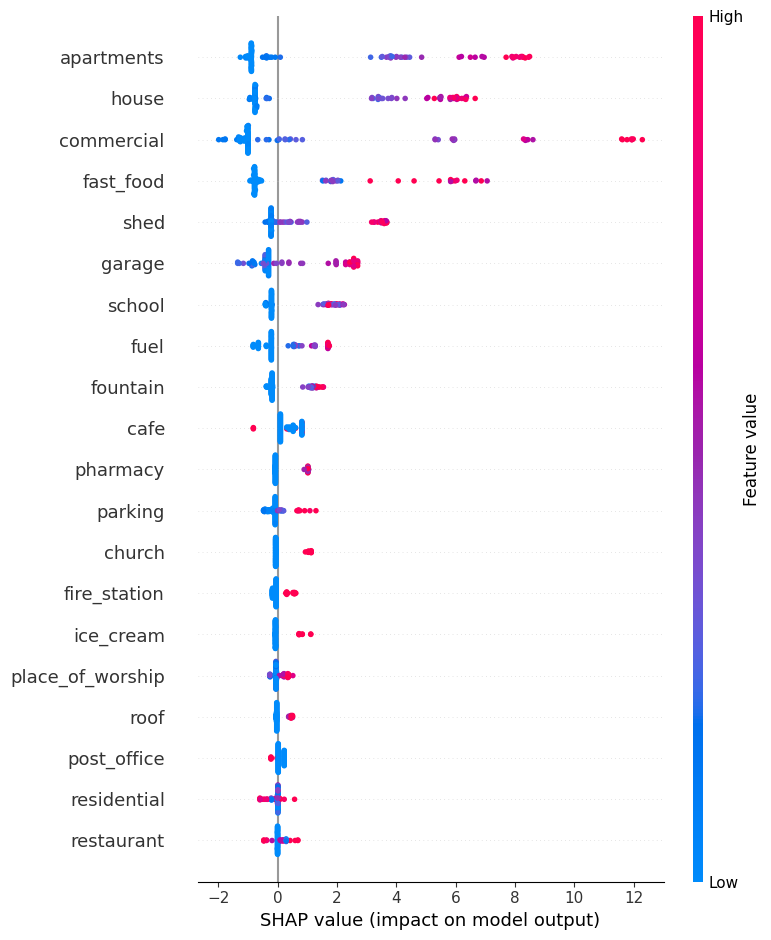

In [200]:
import shap
import matplotlib.pyplot as plt



# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_values = explainer.shap_values(X_test_reguli)

shap_values_test = explainer.shap_values(X_test_reguli)*ohca_reguli_inverse
# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(shap_values_test, X_test_reguli,feature_names, max_display=20)
# # 顯示每個特徵的平均影響力 (特徵重要性條形圖)
# shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])

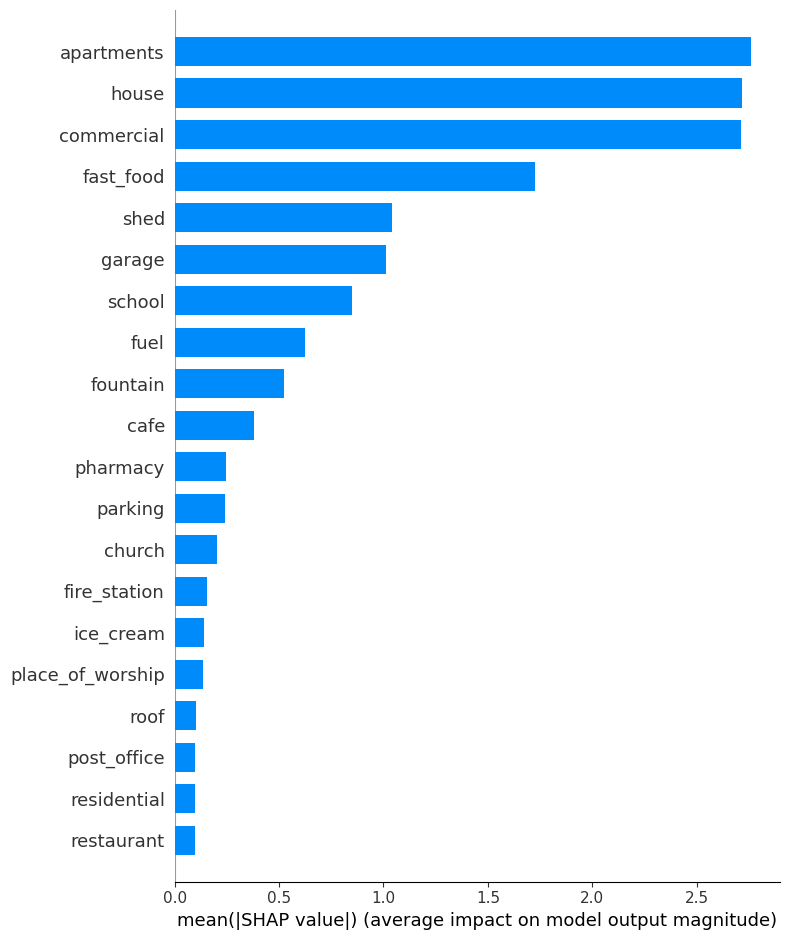

In [201]:
shap.summary_plot(shap_values_test, X_test_reguli,feature_names , plot_type="bar",  max_display=20)

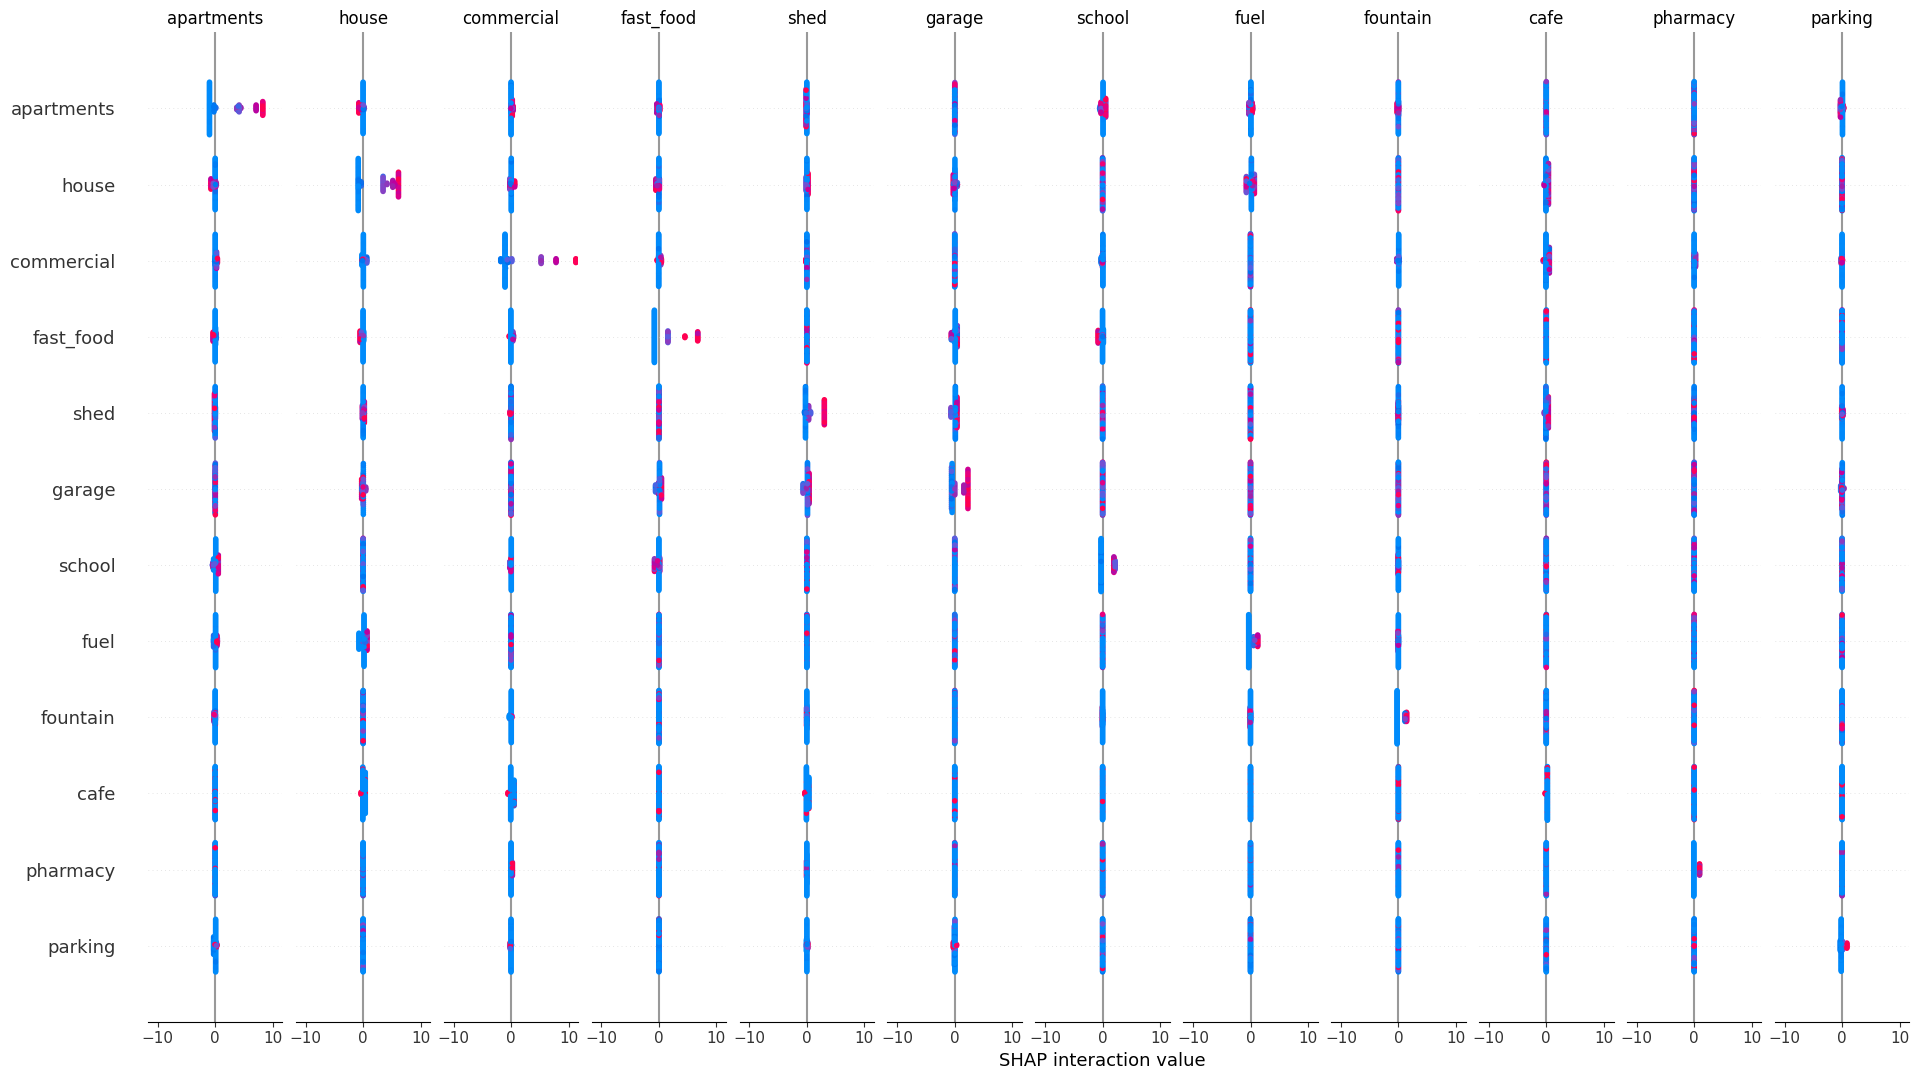

<Figure size 640x480 with 0 Axes>

In [202]:
# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_interaction_values = explainer.shap_interaction_values(X_test_reguli)*ohca_reguli_inverse

# 提取第一個樣本的第 0 和第 1 個特徵的交互值
interaction_0_1 = shap_interaction_values[0][0, 1]

# 繪製 SHAP 交互值矩陣圖
shap.summary_plot(shap_interaction_values, X_test_reguli,feature_names,max_display=12)

# XGBoost 內建

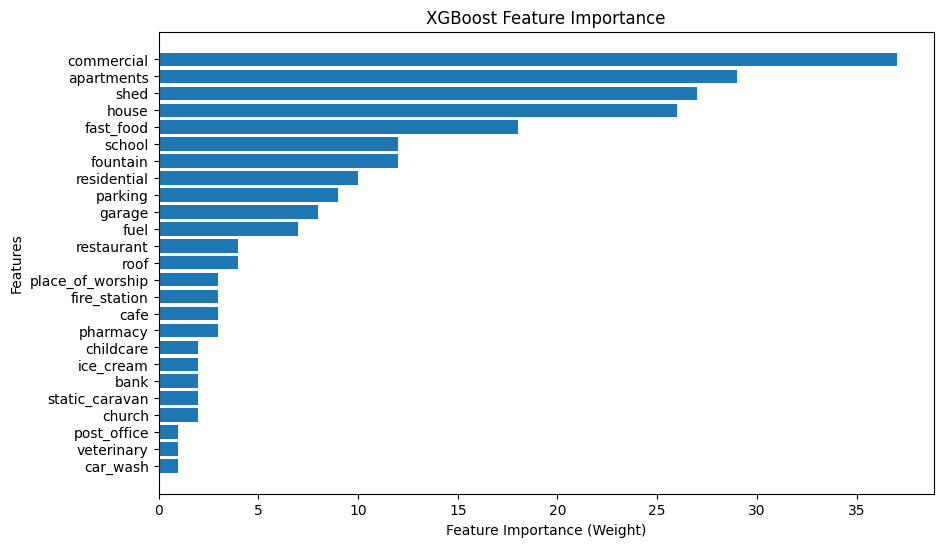

In [203]:
# 取得特徵重要性
importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# 轉換為排序好的列表
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 轉換 'fXX' 為對應的 feature_names[XX]
updated_importance = [(feature_names[int(f[1:])], score) for f, score in sorted_features]

features, values = zip(*updated_importance)

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(features, values)
plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # 讓重要性高的特徵排在上方
plt.show()

# SVM(Different Kernel)

In [204]:
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_absolute_error, r2_score
# from sklearn.preprocessing import StandardScaler

# # 正規化數據 (將特徵縮放到相同範圍，以提高模型的穩定性)
# scaler = StandardScaler()
# normalized_spatial_data = scaler.fit_transform(h3_spatial_data)

# # 設定不同的核函數類型 (SVM 支援的四種主要核函數)
# kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# # 用於存儲每個核函數的結果
# results = {}

# # 迴圈遍歷每種核函數
# for kernel in kernels:
#     print(f"Training with {kernel} kernel...")
    
#     # 設定 GridSearchCV 的超參數網格，測試不同的 C 和 epsilon 組合
#     param_grid = {
#         'C': [0.001, 0.01, 0.05, 0.1, 1],  # C 值較小時增加正則化效果
#         'epsilon': [1e-5, 1e-4, 1e-3, 0.01, 0.05],  # epsilon 越小，模型對誤差的容忍度越低
#         'kernel': [kernel],  # 使用當前核函數
#     }

#     # 初始化 SVR 模型
#     svr = SVR()

#     # 使用 GridSearchCV 進行超參數調整
#     grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

#     # 訓練模型
#     grid_search.fit(X_train_reguli, y_train_reguli)

#     # 取得最佳模型
#     best_svr_model = grid_search.best_estimator_

#     # 進行預測並評估表現 (轉換回原始尺度)
#     y_pred_train = best_svr_model.predict(X_train_reguli) * ohca_reguli_inverse
#     y_pred_test = best_svr_model.predict(X_test_reguli) * ohca_reguli_inverse

#     # 計算 MAE (平均絕對誤差) 和 R² (決定係數)
#     mae_train = mean_absolute_error(y_train_reguli * ohca_reguli_inverse, y_pred_train)
#     mae_test = mean_absolute_error(y_test_reguli * ohca_reguli_inverse, y_pred_test)

#     r2_train = r2_score(y_train_reguli * ohca_reguli_inverse, y_pred_train)
#     r2_test = r2_score(y_test_reguli * ohca_reguli_inverse, y_pred_test)

#     # 存儲結果
#     results[kernel] = {
#         'Best Parameters': grid_search.best_params_,  # 最佳參數組合
#         'Best Score': grid_search.best_score_,  # 最佳分數 (負 MAE)
#         'MAE (Train)': mae_train,  # 訓練集 MAE
#         'MAE (Test)': mae_test,  # 測試集 MAE
#         'R² (Train)': r2_train,  # 訓練集 R²
#         'R² (Test)': r2_test  # 測試集 R²
#     }

#     # 輸出結果
#     print(f"Best Parameters for {kernel}: {grid_search.best_params_}")
#     print(f"Best Score for {kernel}: {grid_search.best_score_}")
#     print(f"MAE (Train) for {kernel}: {mae_train}")
#     print(f"MAE (Test) for {kernel}: {mae_test}")
#     print(f"R² (Train) for {kernel}: {r2_train}")
#     print(f"R² (Test) for {kernel}: {r2_test}")
#     print("-" * 50)

# # 輸出所有核函數的結果摘要
# print("\nSummary of Results:")
# for kernel, result in results.items():
#     print(f"Kernel: {kernel}")
#     for key, value in result.items():
#         print(f"{key}: {value}")
#     print("-" * 50)




In [205]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# 正規化數據 (將特徵縮放到相同範圍，以提高模型的穩定性)
scaler = StandardScaler()
normalized_spatial_data = scaler.fit_transform(h3_spatial_data)

# 設定 SVR 參數
kernel = 'linear'  # 指定核函數
C = 1  # 指定 C 參數
epsilon = 0.05  # 指定 epsilon 參數

# 初始化 SVR 模型
svr = SVR(kernel=kernel, C=C, epsilon=epsilon)

# 訓練模型
svr.fit(X_train_reguli, y_train_reguli)

# 進行預測並評估表現 (轉換回原始尺度)
y_pred_train = svr.predict(X_train_reguli) * ohca_reguli_inverse
y_pred_test = svr.predict(X_test_reguli) * ohca_reguli_inverse


# 計算 MAE (平均絕對誤差) 和 R² (決定係數)
mae_train = mean_absolute_error(y_train_reguli * ohca_reguli_inverse, y_pred_train)
mae_test = mean_absolute_error(y_test_reguli * ohca_reguli_inverse, y_pred_test)

r2_train = r2_score(y_train_reguli * ohca_reguli_inverse, y_pred_train)
r2_test = r2_score(y_test_reguli * ohca_reguli_inverse, y_pred_test)


# 輸出結果
print(f"Kernel: {kernel}")
print(f"C: {C}")
print(f"Epsilon: {epsilon}")
print(f"MAE (Train): {mae_train}")
print(f"MAE (Test): {mae_test}")
print(f"R² (Train): {r2_train}")
print(f"R² (Test): {r2_test}")


Kernel: linear
C: 1
Epsilon: 0.05
MAE (Train): 2.1151099332685366
MAE (Test): 5.870296489834363
R² (Train): 0.9573184939226599
R² (Test): 0.7326980718539038


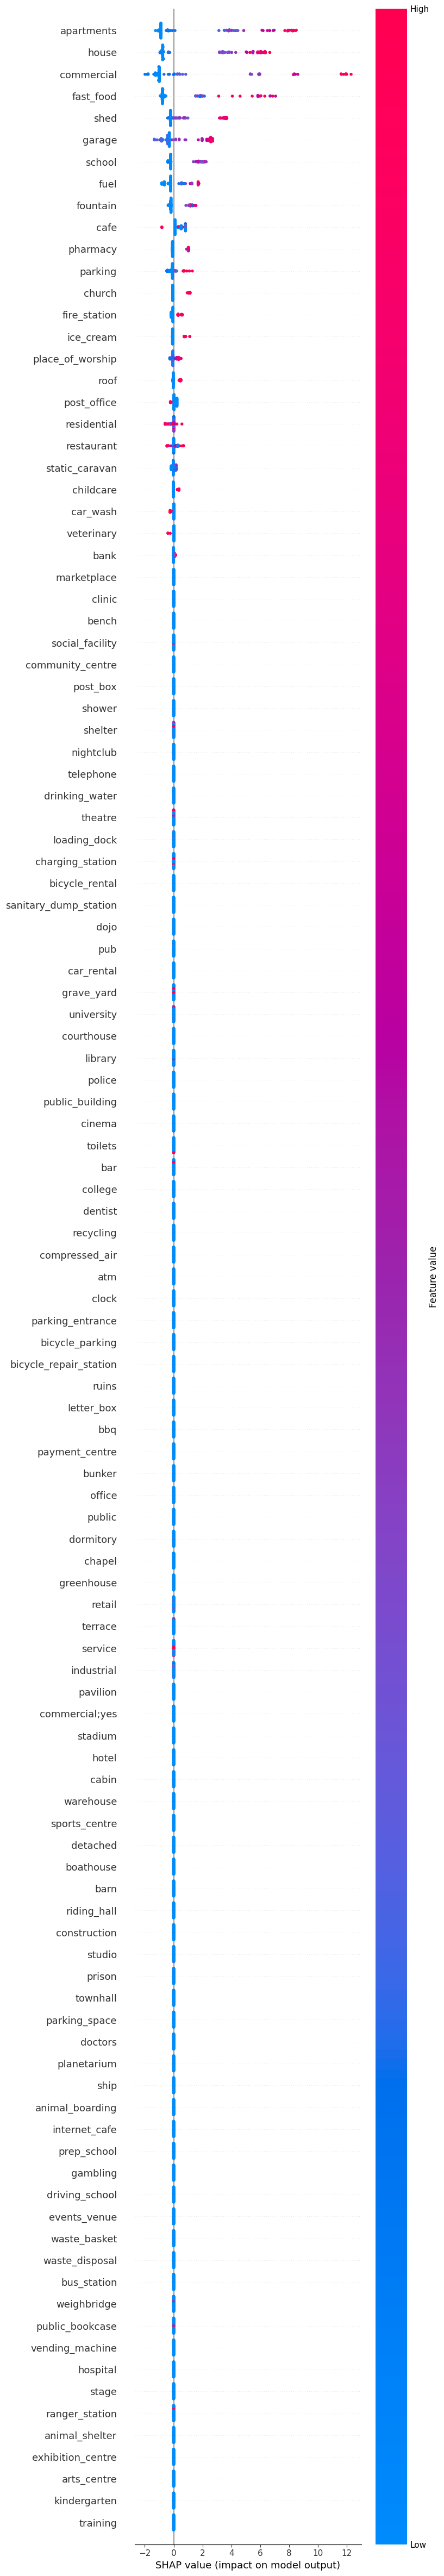

In [206]:
shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])